In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil
import mne
import warnings
import datetime


from data_extraction import  Extract_data_from_subject
from data_processing import  Select_time_window, Transform_for_classificator, Split_trial_in_time
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import TensorBoard
from keras.constraints import max_norm
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold



np.random.seed(23)

mne.set_log_level(verbose='warning') #to avoid info at terminal
warnings.filterwarnings(action = "ignore", category = DeprecationWarning ) 
warnings.filterwarnings(action = "ignore", category = FutureWarning ) 


#%load_ext tensorboard
#%tensorboard --logdir logs

# Notes on Data Extraction:

### Parameters
> - Sampling Rate (fs) = 256
> - data type: eeg, exg or baseline
> - T-start: start of window (t=0: focus, t=0.5: arrow, t=1: cue (thinking), t=3.5: rest t=4.5: end)
> - T-end: close of window
> - N_S: subject number (1 through 10)
> - N_B: Session (batch) number

### Extract_subject_from_BDF(root_dir,N_S,N_B):

> Loads raw data for subject and session. Takes the directory pointing to folder containing all recordings
> and preprocessed files, subject number and session/batch number, and returns (raw data, subject number)

### Extract_data_from_subject(root_dir,N_S,datatype):

> Loads all blocks for one subject and stacks results. Takes the directory, calls the file for specified data 
> under the specified subject, and stacks all samples into one object. Also calls the labels. Returns (X,Y): 
> object with stacked trials/samples, and object with correlated labels.

### Extract_block_data_from_subject(root_dir,N_S,datatype,N_B):

> Does the same as above Extract_data_from_subject, but for a specified N_B (batch or session number).
> returns (data samples, labels)

### Extract_report(root_dir,N_B,N_S):

> Pulls report with information regarding the given subject and session. Includes subject age, gender,
> length of recording, count of correct and incorrect answer to control questions, position of contaminated
> trials, mean power for EXG channels 7 & 8, and mean and STD for EXG 7 & 8 baseline recordings.

### Extract_TFR(TRF_dir, Cond, Class, TFR_method , TRF_type):

> Returns Time-Frequency Representation of specified condition and class. 
>
> *Note: location of TRF data unclear, not likely to use in scope of project.*

### Extract_data_multisubject(root_dir, N_S_list, datatype='EEG'):

> Creates a stacked object of all sessions for all listed subjects and returns the stacked trials/samples
> along with a stack of the corresponding labels.

### load_events(root_dir,N_S,N_B):

> Loads the events file to gather the label(s) for dataset using root directory, subject, and batch number.

### Select_time_window(X,t_start=1, t_end=2.5, fs=256):

> Cuts samples to desired time window.

### Transform_for_classificator (X, Y, Classes, Conditions):

> Pulls from the extracted dataset the trials and labels that correspond to the conditions and classes that
> will be used for training and/or testing.


In [2]:
root_dir = '/kaggle/input/inner-speech-recognition/inner-speech-recognition'

In [3]:
N_S = 9
datatype = 'eeg'
Tstart = 1.5
Tend = 3.5
fs = 256

X,Y = Extract_data_from_subject(root_dir,N_S,datatype)

In [4]:
Subj = Select_time_window(X = X, t_start = Tstart, t_end = Tend, fs = fs)

In [5]:
X, Y = Transform_for_classificator(X = Subj, Y = Y, Classes = [['ALL']], Conditions = [['Inner']])

In [6]:
input_shape = (X.shape[1],X.shape[2],1)
print(input_shape)



(128, 512, 1)


In [7]:
# one-hot encoding
Y[:,(0,1)].shape
# print(Labels_2_inner[:,(0,1)])
labels = Y[:,1]
y = pd.get_dummies(labels)


In [8]:
X.shape

(240, 128, 512)

In [9]:
Adquisition_eq="biosemi128"
montage = mne.channels.make_standard_montage(Adquisition_eq)
info = mne.create_info(ch_names=X.shape[1], sfreq=256, ch_types='eeg')


In [10]:
montage

<DigMontage | 0 extras (headshape), 0 HPIs, 3 fiducials, 128 channels>

In [11]:
mapping = {str(i): ch_name for i, ch_name in enumerate(montage.ch_names)}
info.rename_channels(mapping)

<Info | 7 non-empty values
 bads: []
 ch_names: A1, A2, A3, A4, A5, A6, A7, A8, A9, A10, A11, A12, A13, A14, ...
 chs: 128 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 128.0 Hz
 meas_date: unspecified
 nchan: 128
 projs: []
 sfreq: 256.0 Hz
>

In [12]:
mapping = {ch_name: 'eeg' for ch_name in montage.ch_names}
info.set_channel_types(mapping)

<Info | 7 non-empty values
 bads: []
 ch_names: A1, A2, A3, A4, A5, A6, A7, A8, A9, A10, A11, A12, A13, A14, ...
 chs: 128 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 128.0 Hz
 meas_date: unspecified
 nchan: 128
 projs: []
 sfreq: 256.0 Hz
>

In [13]:
info.set_montage(montage, on_missing='warn')

<Info | 8 non-empty values
 bads: []
 ch_names: A1, A2, A3, A4, A5, A6, A7, A8, A9, A10, A11, A12, A13, A14, ...
 chs: 128 EEG
 custom_ref_applied: False
 dig: 131 items (3 Cardinal, 128 EEG)
 highpass: 0.0 Hz
 lowpass: 128.0 Hz
 meas_date: unspecified
 nchan: 128
 projs: []
 sfreq: 256.0 Hz
>

In [14]:
X.shape
reshaped_data = X[1]
#reshaped_data.shape
X.shape

(240, 128, 512)

In [15]:
#reshaped_data = X.reshape((X.shape[0] * X.shape[1], X.shape[2]))

#mean_data = np.mean(reshaped_data.reshape((X.shape[0], X.shape[1], X.shape[2])), axis=0)

#mean_data.shape 


In [16]:
mean_data = np.mean(X, axis=0)

In [17]:
mean_data.shape

(128, 512)

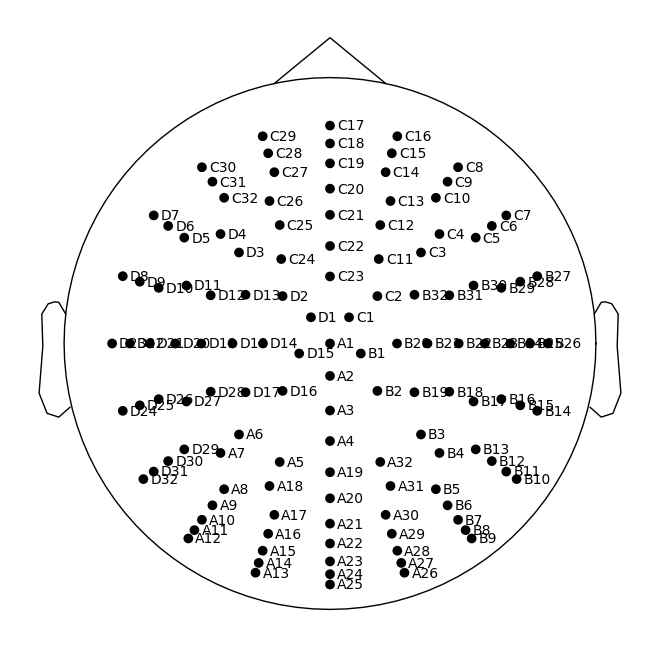

In [18]:
# Create a RawArray object using reshaped data
raw = mne.io.RawArray(X[1], info)

# Plot the sensors with the applied montage
fig = raw.plot_sensors(show_names=True)


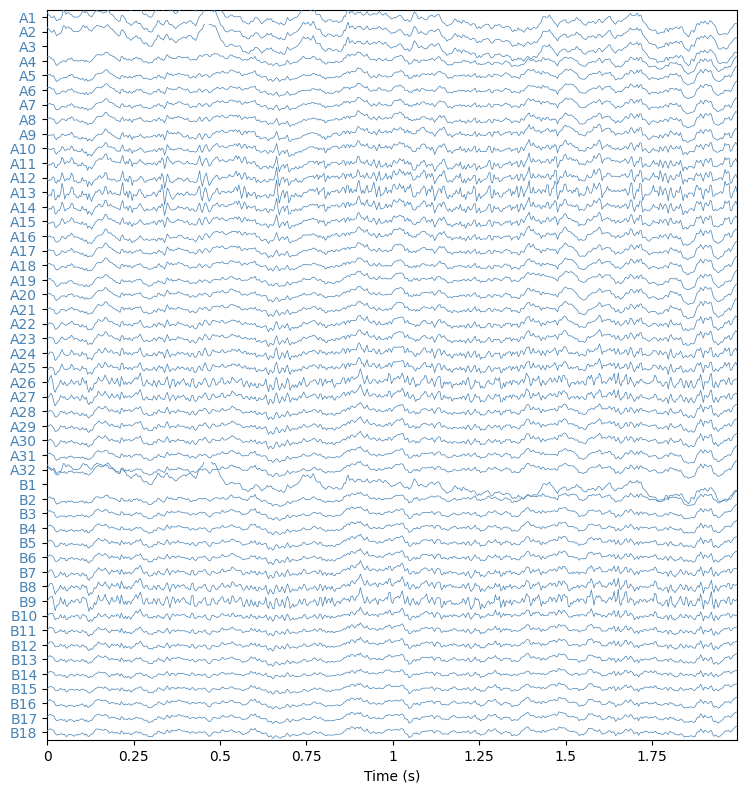

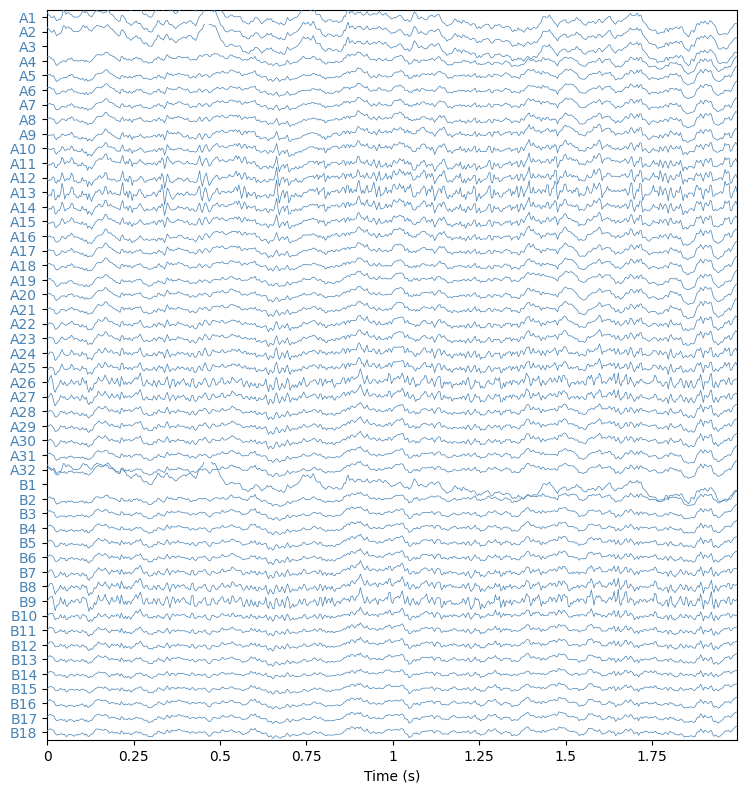

In [19]:
raw.plot(n_channels=50, color = 'steelblue',show_scrollbars= False, show_scalebars= False, time_format="float")


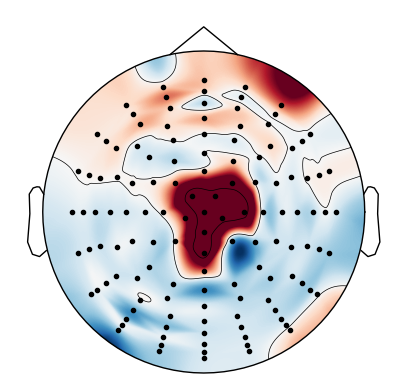

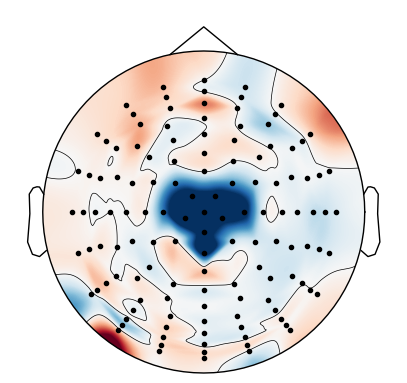

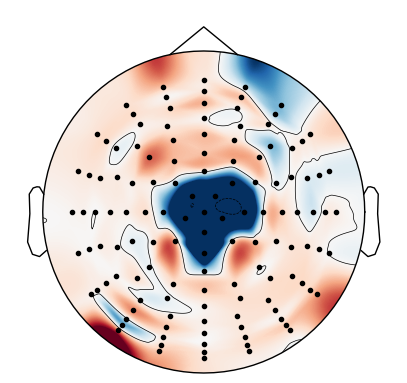

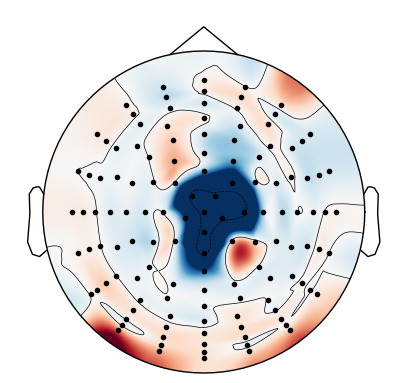

In [20]:
import mne
import numpy as np

# Assuming 'raw' is your Raw object

# Number of time segments
num_segments = 4
segment_size = raw.n_times // num_segments

# Plot topoplots for each segment
for i in range(num_segments):
    start_idx = i * segment_size
    end_idx = (i + 1) * segment_size if i < num_segments - 1 else raw.n_times
    mean_data = np.mean(raw.get_data()[:, start_idx:end_idx], axis=1)
    
    info = raw.info

    mne.viz.plot_topomap(mean_data, info, show=True, contours= True, res=300, sensors='k.', size=5, vlim =(-0.00001,0.00001))


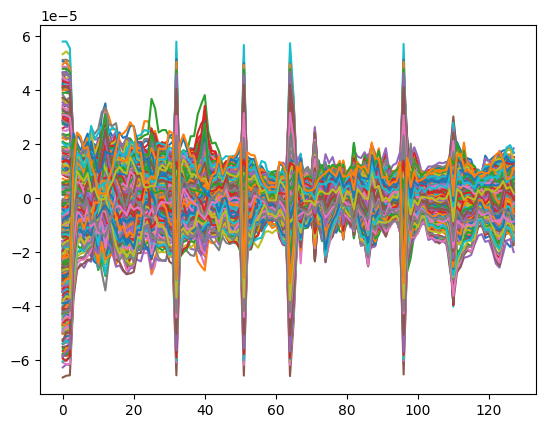

In [21]:
plt.plot(X[1,:,:]);

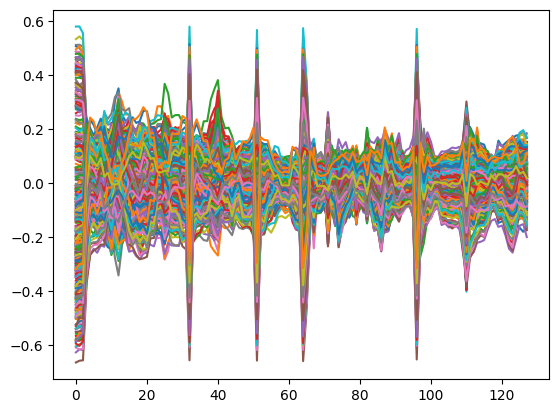

In [22]:
# new scaling 
X_N = X * (10**4)
plt.plot(X_N[1,:,:]);

## 2. Implement CNN

In [23]:
# split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X_N, y, test_size=0.2)


In [24]:
# Define a learning rate schedule
#learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#    initial_learning_rate=0.0001,
#    decay_steps=10000,
#    decay_rate=0.96
#)

Adam_ = tf.keras.optimizers.Adam(learning_rate=0.0001, weight_decay=0.001)


def create_cnn(input_shape):
    # create model - Sequential class, linear stack of layers can be added
    model = models.Sequential()
    # first layer 
    model.add(layers.Conv2D(32, kernel_size = (1,5), padding = 'valid', activation='relu', input_shape = input_shape, strides = (1,2)))
    # adds max pooling layer
    model.add(layers.MaxPooling2D(pool_size=(1, 2)))
    # second layer
    model.add(layers.Conv2D(32, kernel_size = (1,5), padding = 'valid', activation='relu'))
    # adds max pooling layer
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    # flatten output before last convolutional layer
    model.add(layers.Flatten())
    # Add a fully connected layer 
    model.add(layers.Dense(3000, activation='relu'))
    # Add Dropout for regularization
    model.add(layers.Dropout(0.5)) # 0.2 is the default
    # Output layer 
    model.add(layers.Dense(4, activation='softmax'))

    # Compile model
    model.compile( 
        optimizer = 'adam', # default
        loss = 'categorical_crossentropy',
        metrics = ['accuracy'],
        )    
    
    return model

model = create_cnn(input_shape)

model.summary()                   

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 254, 32)      192       
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 123, 32)      5152      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 61, 32)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 124928)            0         
                                                                 
 dense (Dense)               (None, 3000)              3

## EEGNET Version

In [25]:
def EEGNet(input_shape): 
    model = models.Sequential()
    
    model.add(layers.Conv2D(8, kernel_size = (1,64), padding = 'same', input_shape = input_shape))
    model.add(layers.BatchNormalization())
    
    model.add(layers.DepthwiseConv2D((128,1), depth_multiplier = 2, depthwise_constraint = max_norm(1.)))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.AveragePooling2D(pool_size=(1, 4)))    
    model.add(layers.SpatialDropout2D(0.25))
    
    model.add(layers.SeparableConv2D(16, kernel_size = (1,16), padding = 'same'))
    model.add(layers.BatchNormalization()) 
    model.add(layers.Activation('relu'))
    model.add(layers.AveragePooling2D(pool_size=(1, 8)))    
    model.add(layers.SpatialDropout2D(0.25))
              
    model.add(layers.Flatten())
    model.add(layers.Dense(4, activation='softmax'))
    
    # Compile model
    model.compile( 
        optimizer = 'adam', # default
        loss = 'categorical_crossentropy',
        metrics = ['accuracy'],
        ) 
              
    return model

model = EEGNet(input_shape)

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 128, 512, 8)       520       
                                                                 
 batch_normalization (Batch  (None, 128, 512, 8)       32        
 Normalization)                                                  
                                                                 
 depthwise_conv2d (Depthwis  (None, 1, 512, 16)        2064      
 eConv2D)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 1, 512, 16)        64        
 chNormalization)                                                
                                                                 
 activation (Activation)     (None, 1, 512, 16)        0         
                                                      

In [26]:
#log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# Define the TensorBoard callback
#tensorboard_callback = tf.keras.callbacks.TensorBoard(
 #   log_dir= log_dir,  # Specify the directory where TensorBoard logs will be stored
 #   histogram_freq=1,  # Record histogram data every epoch
        #write_graph=True,   # Write the graph to TensorBoard
        #write_images=True   # Write model weights as images to TensorBoard
#)
 
# Early Stopping    
EarlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Reduce Learning Rate
ReduceLR = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    mode='auto',
    min_lr=0.00001,
)

# Train model
def fit_evaluate(X_train, X_val,  y_train, y_val, epochs, batch_size): 
    model = EEGNet(input_shape)
    results = model.fit(X_train, y_train, epochs = epochs, batch_size = batch_size, verbose= 1, callbacks=[EarlyStopping, ReduceLR], validation_split = 0.1)
    print("Val Score: ", model.evaluate(X_val, y_val))
    
    return results


In [27]:
n_folds = 5
epochs = 50
batch_size = 16

skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=0)
train_fold = []
val_fold = []
model_history = []

for train_ind, val_ind in skf.split(X_train, np.argmax(y_train, axis=1)):
    train_fold.append(train_ind)
    val_fold.append(val_ind)

for i in range(n_folds):
    print("Training on Fold: ", i + 1)
    
    X_train_i = X_train[train_fold[i]]
    y_train_i = y_train.values[train_fold[i]]  # Convert to NumPy array
    
    X_val_i = X_train[val_fold[i]]
    y_val_i = y_train.values[val_fold[i]]  # Convert to NumPy array
    
    model_history.append(fit_evaluate(X_train_i, X_val_i, y_train_i, y_val_i, epochs, batch_size))
    
    print("=======" * 12, end="\n\n\n")

Training on Fold:  1
Epoch 1/50
9/9 [==============================] - 9s 780ms/step - loss: 1.6569 - accuracy: 0.2628 - val_loss: 1.3924 - val_accuracy: 0.1875 - lr: 0.0010
Epoch 2/50
9/9 [==============================] - 7s 735ms/step - loss: 1.5289 - accuracy: 0.2336 - val_loss: 1.3979 - val_accuracy: 0.1250 - lr: 0.0010
Epoch 3/50
9/9 [==============================] - 7s 719ms/step - loss: 1.4408 - accuracy: 0.2701 - val_loss: 1.4009 - val_accuracy: 0.1250 - lr: 0.0010
Epoch 4/50
2/2 [==============================] - 1s 68ms/step - loss: 1.3861 - accuracy: 0.2564
Val Score:  [1.3860700130462646, 0.25641027092933655]


Training on Fold:  2
Epoch 1/50
9/9 [==============================] - 9s 766ms/step - loss: 1.6149 - accuracy: 0.2190 - val_loss: 1.3888 - val_accuracy: 0.2500 - lr: 0.0010
Epoch 2/50
9/9 [==============================] - 7s 725ms/step - loss: 1.4328 - accuracy: 0.2847 - val_loss: 1.3900 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/50
9/9 [====================

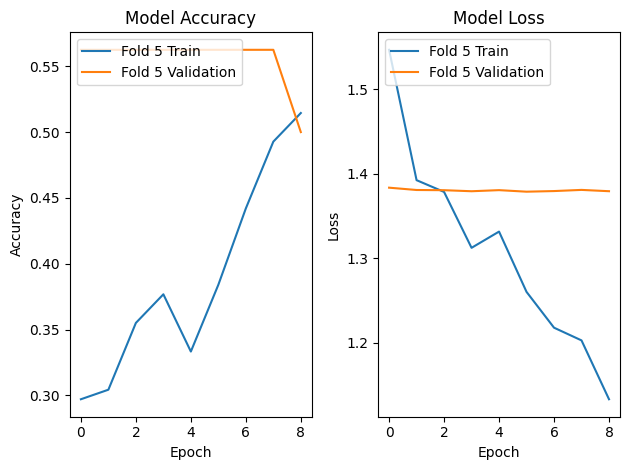

In [28]:
# Find the fold with the best validation accuracy
best_fold_idx = np.argmax([np.max(model_history[i].history['val_accuracy']) for i in range(n_folds)])

# Create subplots
fig, ax = plt.subplots(nrows=1, ncols=2)

# Plot the best fold
ax[0].plot(model_history[best_fold_idx].history['accuracy'], label=f'Fold {best_fold_idx + 1} Train')
ax[0].plot(model_history[best_fold_idx].history['val_accuracy'], label=f'Fold {best_fold_idx + 1} Validation')

ax[1].plot(model_history[best_fold_idx].history['loss'], label=f'Fold {best_fold_idx + 1} Train')
ax[1].plot(model_history[best_fold_idx].history['val_loss'], label=f'Fold {best_fold_idx + 1} Validation')

# Set common titles and labels
ax[0].set_title('Model Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(loc='upper left')

ax[1].set_title('Model Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(loc='upper left')

plt.tight_layout()
plt.show()


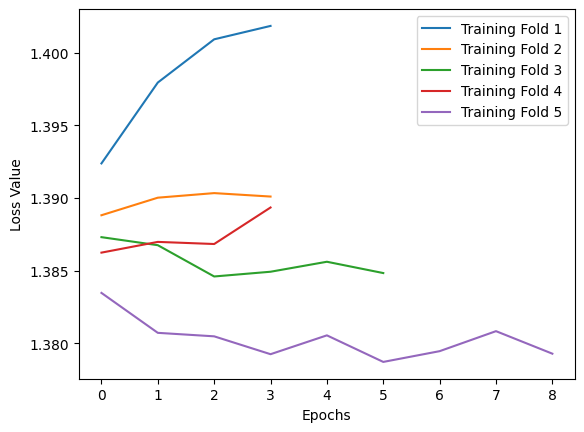

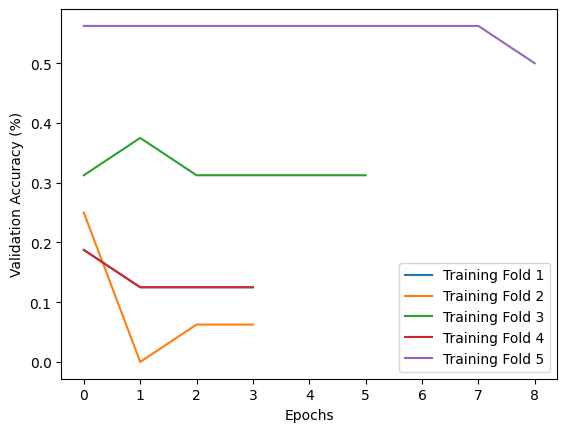

In [29]:
# Visualize history
# Loss
for i in range(n_folds):
    plt.plot(model_history[i].history['val_loss'], label=f'Training Fold {i + 1}')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.show()


# Validation Accuracy
for i in range(n_folds):
    plt.plot(model_history[i].history['val_accuracy'], label=f'Training Fold {i + 1}')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy (%)')
plt.show()



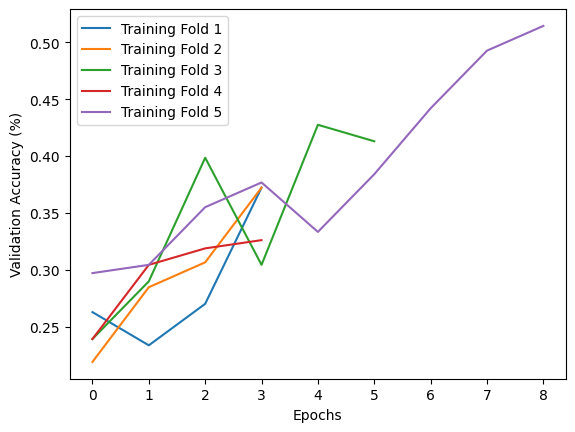

In [30]:
# Validation Accuracy
for i in range(n_folds):
    plt.plot(model_history[i].history['accuracy'], label=f'Training Fold {i + 1}')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy (%)')
plt.show()

In [31]:
#%tensorboard --logdir logs/fit

In [32]:
pred_y = model.predict(
    X_test,
    verbose =1
)

2/2 [==============================] - 1s 115ms/step


In [33]:
print(pred_y)

[[0.2501748  0.2514995  0.24996541 0.24836029]
 [0.24950631 0.25113735 0.24990332 0.2494531 ]
 [0.2502753  0.25113034 0.24979202 0.2488023 ]
 [0.24957332 0.25202155 0.2499241  0.24848093]
 [0.24746224 0.253519   0.25091535 0.24810332]
 [0.24937817 0.25186253 0.24984339 0.24891596]
 [0.24915043 0.2518983  0.24969476 0.24925664]
 [0.24937993 0.2520065  0.24991715 0.24869637]
 [0.24906817 0.25177044 0.24991734 0.24924403]
 [0.24813409 0.25233936 0.25035393 0.24917263]
 [0.24986178 0.25143787 0.25011545 0.24858488]
 [0.24948935 0.2515303  0.25031602 0.24866433]
 [0.24971108 0.2513004  0.25017288 0.24881554]
 [0.24967197 0.251477   0.24988067 0.24897042]
 [0.24827832 0.2521113  0.25075704 0.24885333]
 [0.24893637 0.25176108 0.25005686 0.24924567]
 [0.24963616 0.25099507 0.2504705  0.24889822]
 [0.24939428 0.2512833  0.2503007  0.24902171]
 [0.24798442 0.25389004 0.250313   0.24781255]
 [0.24974234 0.25126567 0.25003782 0.24895406]
 [0.2496497  0.25183195 0.24995045 0.24856791]
 [0.24853401 

In [34]:
score = model.evaluate(
    X_test,
    y_test,
    batch_size = 24,
    verbose =2
)

2/2 - 1s - loss: 1.3863 - accuracy: 0.2500 - 714ms/epoch - 357ms/step


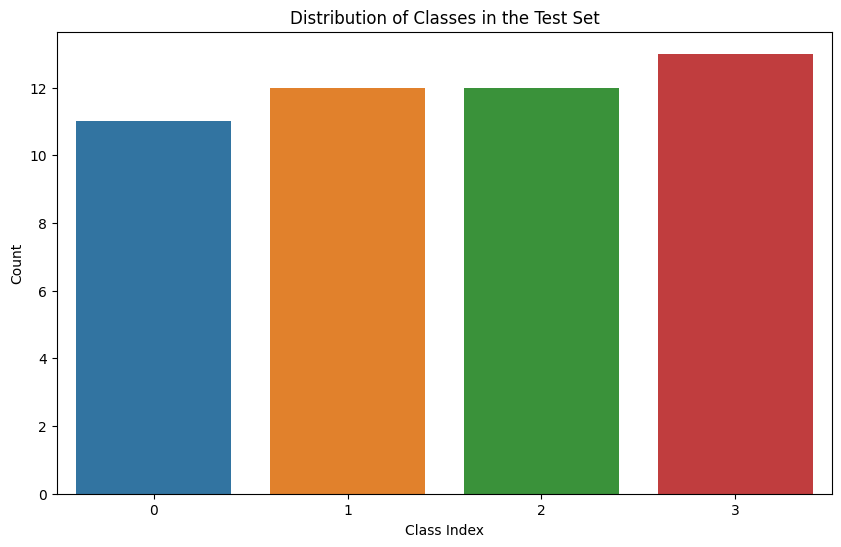

In [35]:
# Sum the occurrences of True values along each column
class_counts = y_test.iloc[:,:].sum()

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Distribution of Classes in the Test Set')
plt.xlabel('Class Index')
plt.ylabel('Count')
plt.show()